# Mining Process: Machine Learning and Analysis

本專案為個人嘗試針對製造產業資料進行機器學習建模與預測，採用資料為礦業精煉過程中的泡沫浮選設備的輸入與產出  
其中的"%Iron Concentrate" 與 "% Silica Concentrate" 等兩種類型數值產出為此過程的最終成果，前者越高對產出品質越佳，後者反之  
相關情境目標是希望能挑選並建立合適的模型來解釋本資料的輸入與對應產出(減低二氧化矽產出)，同時進行模型的初步優化  
以期未來能達到同步接受資料的input下，動態調整其他可控變數，優化最終成果  

資料來源: https://www.kaggle.com/datasets/edumagalhaes/quality-prediction-in-a-mining-process

# Import Library & Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, LogisticRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

from sklearn.metrics import log_loss, mean_squared_error
import optuna
import shap

In [2]:
df = pd.read_csv('./input/MiningProcess_Flotation_Plant_Database.csv',
                 decimal=",",
                 parse_dates=["date"],
                 infer_datetime_format=True
                )

# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date                          737453 non-null  datetime64[ns]
 1   % Iron Feed                   737453 non-null  float64       
 2   % Silica Feed                 737453 non-null  float64       
 3   Starch Flow                   737453 non-null  float64       
 4   Amina Flow                    737453 non-null  float64       
 5   Ore Pulp Flow                 737453 non-null  float64       
 6   Ore Pulp pH                   737453 non-null  float64       
 7   Ore Pulp Density              737453 non-null  float64       
 8   Flotation Column 01 Air Flow  737453 non-null  float64       
 9   Flotation Column 02 Air Flow  737453 non-null  float64       
 10  Flotation Column 03 Air Flow  737453 non-null  float64       
 11  Flotation Col

In [4]:
df['time_date'] = df['date'].dt.date
df['time_o_clock'] = df.date.dt.hour

In [5]:
df['time_date'].value_counts()

2017-06-16    4320
2017-07-18    4320
2017-07-10    4320
2017-07-11    4320
2017-07-12    4320
              ... 
2017-05-23    4320
2017-04-10    4319
2017-03-10    4134
2017-03-29    2160
2017-03-16    1080
Name: time_date, Length: 172, dtype: int64

<AxesSubplot:>

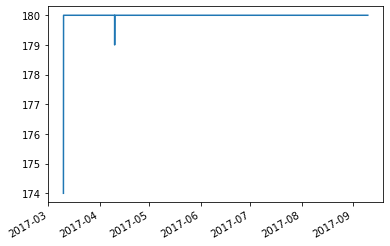

In [6]:
df['date'].value_counts().plot()

In [7]:
df['date'].value_counts()

2017-06-16 15:00:00    180
2017-06-16 16:00:00    180
2017-07-14 18:00:00    180
2017-07-14 19:00:00    180
2017-07-14 20:00:00    180
                      ... 
2017-05-19 11:00:00    180
2017-05-19 12:00:00    180
2017-05-19 13:00:00    180
2017-04-10 00:00:00    179
2017-03-10 01:00:00    174
Name: date, Length: 4097, dtype: int64

基本上每20s會有一筆資料，無法確認缺少record的時間點對產出相關是否有影響  
根據相關領域知識所知，大概10分鐘左右可以完成製程，在此暫時假定無時間位移對產出的影響   

In [8]:
df.drop(columns = {'time_date', 'time_o_clock'}, inplace= True)
df.drop(columns = {'date'}, inplace= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   % Iron Feed                   737453 non-null  float64
 1   % Silica Feed                 737453 non-null  float64
 2   Starch Flow                   737453 non-null  float64
 3   Amina Flow                    737453 non-null  float64
 4   Ore Pulp Flow                 737453 non-null  float64
 5   Ore Pulp pH                   737453 non-null  float64
 6   Ore Pulp Density              737453 non-null  float64
 7   Flotation Column 01 Air Flow  737453 non-null  float64
 8   Flotation Column 02 Air Flow  737453 non-null  float64
 9   Flotation Column 03 Air Flow  737453 non-null  float64
 10  Flotation Column 04 Air Flow  737453 non-null  float64
 11  Flotation Column 05 Air Flow  737453 non-null  float64
 12  Flotation Column 06 Air Flow  737453 non-nul

In [9]:
df.describe().T

count         mean          std         min  \
% Iron Feed                   737453.0    56.294739     5.157744   42.740000   
% Silica Feed                 737453.0    14.651716     6.807439    1.310000   
Starch Flow                   737453.0  2869.140569  1215.203734    0.002026   
Amina Flow                    737453.0   488.144697    91.230534  241.669000   
Ore Pulp Flow                 737453.0   397.578372     9.699785  376.249000   
Ore Pulp pH                   737453.0     9.767639     0.387007    8.753340   
Ore Pulp Density              737453.0     1.680380     0.069249    1.519820   
Flotation Column 01 Air Flow  737453.0   280.151856    29.621288  175.510000   
Flotation Column 02 Air Flow  737453.0   277.159965    30.149357  175.156000   
Flotation Column 03 Air Flow  737453.0   281.082397    28.558268  176.469000   
Flotation Column 04 Air Flow  737453.0   299.447794     2.572538  292.195000   
Flotation Column 05 Air Flow  737453.0   299.917814     3.636579  286.295000   
Flotation Column 06 Air Flow  737453.0   292.071485    30.217804  189.928000   
Flotation Column 07 Air Flow  737453.0   290.754856    28.670105  185.962000   
Flotation Column 01 Level     737453.0   520.244823   131.014924  149.218000   
Flotation Column 02 Level     737453.0   522.649555   128.165050  210.752000   
Flotation Column 03 Level     737453.0   531.352662   150.842164  126.255000   
Flotation Column 04 Level     737453.0   420.320973    91.794432  162.201000   
Flotation Column 05 Level     737453.0   425.251706    84.535822  166.991000   
Flotation Column 06 Level     737453.0   429.941018    89.862225  155.841000   
Flotation Column 07 Level     737453.0   421.021231    84.891491  175.349000   
% Iron Concentrate            737453.0    65.050068     1.118645   62.050000   
% Silica Concentrate          737453.0     2.326763     1.125554    0.600000   

                                      25%          50%          75%  \
% Iron Feed                     52.670000    56.080000    59.720000   
% Silica Feed                    8.940000    13.850000    19.600000   
Starch Flow                   2076.320000  3018.430000  3727.730000   
Amina Flow                     431.796000   504.393000   553.257000   
Ore Pulp Flow                  394.264000   399.249000   402.968000   
Ore Pulp pH                      9.527360     9.798100    10.038000   
Ore Pulp Density                 1.647310     1.697600     1.728330   
Flotation Column 01 Air Flow   250.281000   299.344000   300.149000   
Flotation Column 02 Air Flow   250.457000   296.223000   300.690000   
Flotation Column 03 Air Flow   250.855000   298.696000   300.382000   
Flotation Column 04 Air Flow   298.262566   299.805000   300.638000   
Flotation Column 05 Air Flow   298.068000   299.887120   301.791137   
Flotation Column 06 Air Flow   262.541000   299.477000   303.061000   
Flotation Column 07 Air Flow   256.302000   299.011000   301.904000   
Flotation Column 01 Level      416.978000   491.878000   594.114000   
Flotation Column 02 Level      441.883000   495.956000   595.464000   
Flotation Column 03 Level      411.325000   494.318000   601.249000   
Flotation Column 04 Level      356.679000   411.974000   485.549000   
Flotation Column 05 Level      357.653000   408.773000   484.329000   
Flotation Column 06 Level      358.497000   424.664575   492.684000   
Flotation Column 07 Level      356.772000   411.065000   476.465000   
% Iron Concentrate              64.370000    65.210000    65.860000   
% Silica Concentrate             1.440000     2.000000     3.010000   

                                     max  
% Iron Feed                     65.78000  
% Silica Feed                   33.40000  
Starch Flow                   6300.23000  
Amina Flow                     739.53800  
Ore Pulp Flow                  418.64100  
Ore Pulp pH                     10.80810  
Ore Pulp Density                 1.85325  
Flotation Column 01 Air Flow   373.87100  
Flotation Column 02 

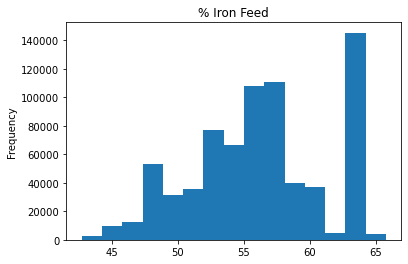

count    737453.000000
mean         56.294739
std           5.157744
min          42.740000
25%          52.670000
50%          56.080000
75%          59.720000
max          65.780000
Name: % Iron Feed, dtype: float64

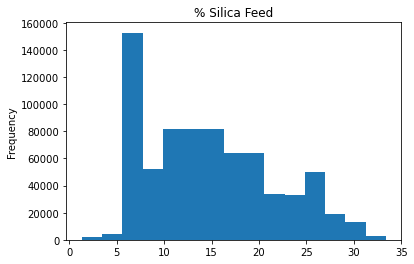

count    737453.000000
mean         14.651716
std           6.807439
min           1.310000
25%           8.940000
50%          13.850000
75%          19.600000
max          33.400000
Name: % Silica Feed, dtype: float64

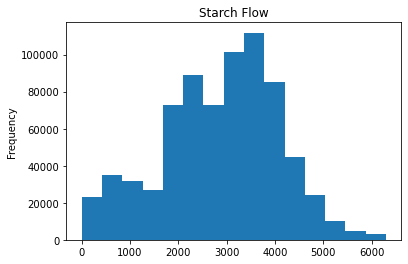

count    737453.000000
mean       2869.140569
std        1215.203734
min           0.002026
25%        2076.320000
50%        3018.430000
75%        3727.730000
max        6300.230000
Name: Starch Flow, dtype: float64

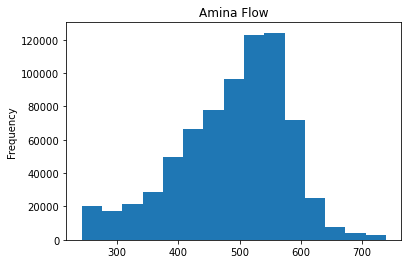

count    737453.000000
mean        488.144697
std          91.230534
min         241.669000
25%         431.796000
50%         504.393000
75%         553.257000
max         739.538000
Name: Amina Flow, dtype: float64

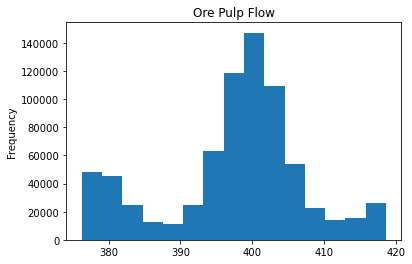

count    737453.000000
mean        397.578372
std           9.699785
min         376.249000
25%         394.264000
50%         399.249000
75%         402.968000
max         418.641000
Name: Ore Pulp Flow, dtype: float64

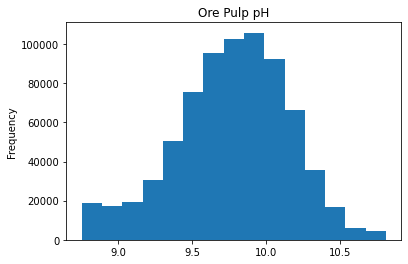

count    737453.000000
mean          9.767639
std           0.387007
min           8.753340
25%           9.527360
50%           9.798100
75%          10.038000
max          10.808100
Name: Ore Pulp pH, dtype: float64

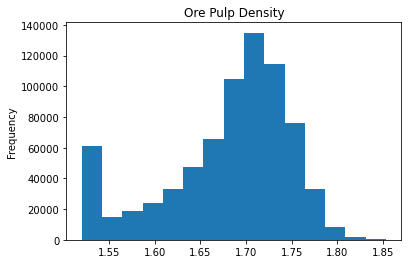

count    737453.000000
mean          1.680380
std           0.069249
min           1.519820
25%           1.647310
50%           1.697600
75%           1.728330
max           1.853250
Name: Ore Pulp Density, dtype: float64

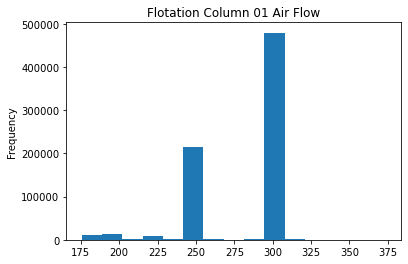

count    737453.000000
mean        280.151856
std          29.621288
min         175.510000
25%         250.281000
50%         299.344000
75%         300.149000
max         373.871000
Name: Flotation Column 01 Air Flow, dtype: float64

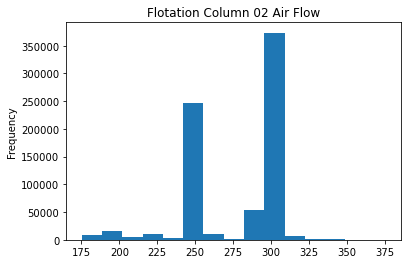

count    737453.000000
mean        277.159965
std          30.149357
min         175.156000
25%         250.457000
50%         296.223000
75%         300.690000
max         375.992000
Name: Flotation Column 02 Air Flow, dtype: float64

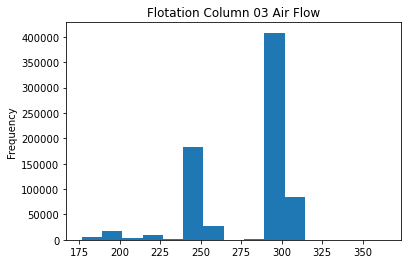

count    737453.000000
mean        281.082397
std          28.558268
min         176.469000
25%         250.855000
50%         298.696000
75%         300.382000
max         364.346000
Name: Flotation Column 03 Air Flow, dtype: float64

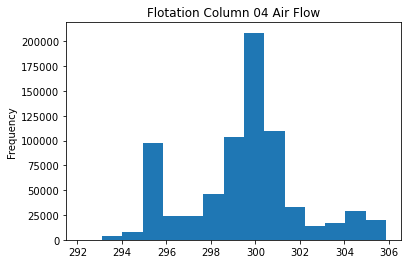

count    737453.000000
mean        299.447794
std           2.572538
min         292.195000
25%         298.262566
50%         299.805000
75%         300.638000
max         305.871000
Name: Flotation Column 04 Air Flow, dtype: float64

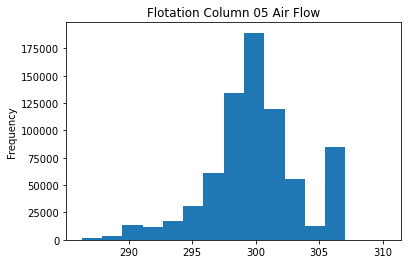

count    737453.000000
mean        299.917814
std           3.636579
min         286.295000
25%         298.068000
50%         299.887120
75%         301.791137
max         310.270000
Name: Flotation Column 05 Air Flow, dtype: float64

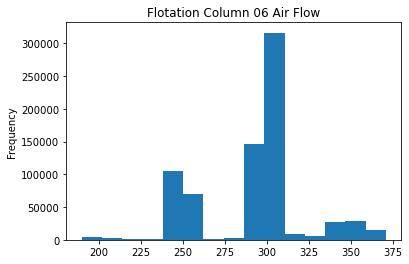

count    737453.000000
mean        292.071485
std          30.217804
min         189.928000
25%         262.541000
50%         299.477000
75%         303.061000
max         370.910000
Name: Flotation Column 06 Air Flow, dtype: float64

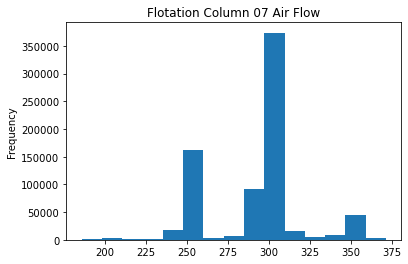

count    737453.000000
mean        290.754856
std          28.670105
min         185.962000
25%         256.302000
50%         299.011000
75%         301.904000
max         371.593000
Name: Flotation Column 07 Air Flow, dtype: float64

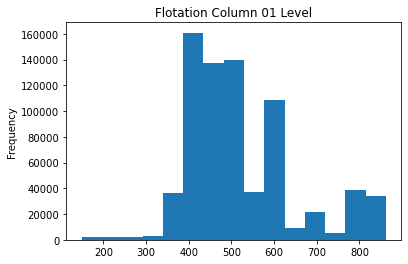

count    737453.000000
mean        520.244823
std         131.014924
min         149.218000
25%         416.978000
50%         491.878000
75%         594.114000
max         862.274000
Name: Flotation Column 01 Level, dtype: float64

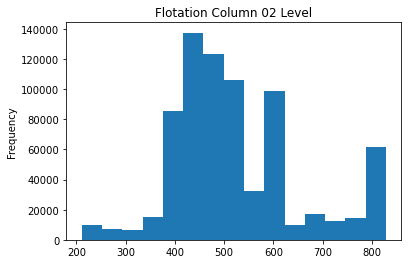

count    737453.000000
mean        522.649555
std         128.165050
min         210.752000
25%         441.883000
50%         495.956000
75%         595.464000
max         828.919000
Name: Flotation Column 02 Level, dtype: float64

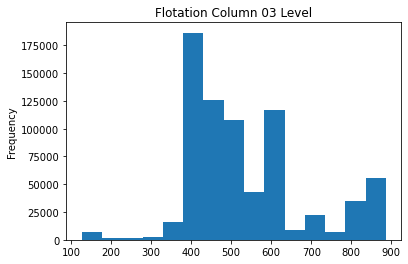

count    737453.000000
mean        531.352662
std         150.842164
min         126.255000
25%         411.325000
50%         494.318000
75%         601.249000
max         886.822000
Name: Flotation Column 03 Level, dtype: float64

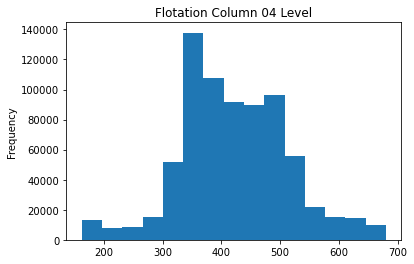

count    737453.000000
mean        420.320973
std          91.794432
min         162.201000
25%         356.679000
50%         411.974000
75%         485.549000
max         680.359000
Name: Flotation Column 04 Level, dtype: float64

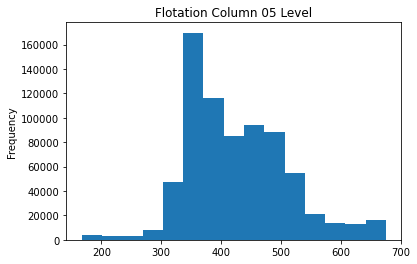

count    737453.000000
mean        425.251706
std          84.535822
min         166.991000
25%         357.653000
50%         408.773000
75%         484.329000
max         675.644000
Name: Flotation Column 05 Level, dtype: float64

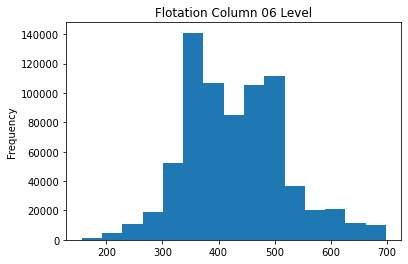

count    737453.000000
mean        429.941018
std          89.862225
min         155.841000
25%         358.497000
50%         424.664575
75%         492.684000
max         698.861000
Name: Flotation Column 06 Level, dtype: float64

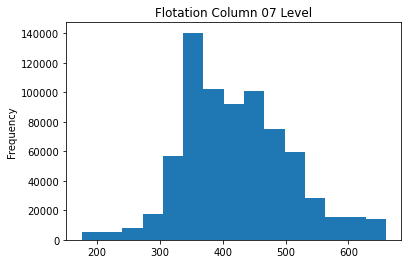

count    737453.000000
mean        421.021231
std          84.891491
min         175.349000
25%         356.772000
50%         411.065000
75%         476.465000
max         659.902000
Name: Flotation Column 07 Level, dtype: float64

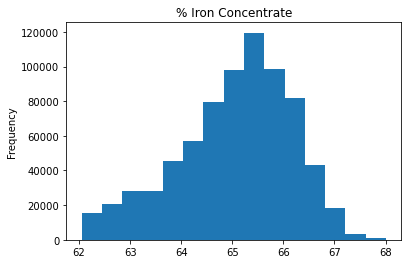

count    737453.000000
mean         65.050068
std           1.118645
min          62.050000
25%          64.370000
50%          65.210000
75%          65.860000
max          68.010000
Name: % Iron Concentrate, dtype: float64

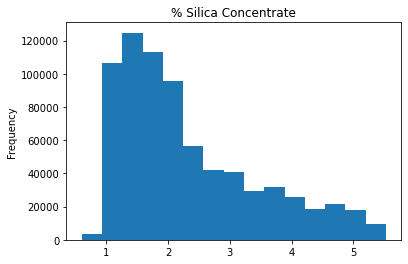

count    737453.000000
mean          2.326763
std           1.125554
min           0.600000
25%           1.440000
50%           2.000000
75%           3.010000
max           5.530000
Name: % Silica Concentrate, dtype: float64

In [10]:
for item in df.keys():
    df[item].plot(title = item, kind = 'hist', bins = 15)
    plt.show()
    display(df[item].describe())
    print('\n')

# Modelling

根據本資料的問題情境，"%Iron Concentrate" 與 "% Silica Concentrate" 兩者皆為泡沫浮選法的產出，前者追求的是越高越好，後者追求的是越低越好  
在本情境中目標是要能降低二氧化矽的百分比，以下將做為主要目標挑選合適的模型  

In [11]:
target_1, target_2 = df['% Iron Concentrate'].copy(), df['% Silica Concentrate'].copy()
feature = df.iloc[:,0:-2].copy()

print('feature list:')
print(feature.keys())

feature list:
Index(['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level'],
      dtype='object')


## Model Baseline

採用LightGBMRegressor作為起始點參考，資料集切分採用7:3，屬於輕量的模型可以較快看到初步結果

In [12]:
#'% Silica Concentrate'作為主要目標(target_2)
print('% Silica Concentrate as training target')

train_X, test_X, train_y, test_y = train_test_split(feature, target_2, test_size = 0.3, random_state = 42)
print('train_X.shape = {},\ntrain_y.shape = {},\ntest_X.shape = {},\ntest_y.shape = {}'.format(train_X.shape, train_y.shape, test_X.shape, test_y.shape))

Model = lgbm.LGBMRegressor()
temp_train_X = train_X.copy()
Model.fit(temp_train_X, train_y)

temp_test_X = test_X.copy()

print('model = ', Model)
print('R2 = {}'.format(Model.score(temp_test_X, test_y)))
    
preds = Model.predict(test_X)
rmse = mean_squared_error(test_y, preds, squared=False)
print('rmse = ', rmse)

% Silica Concentrate as training target
train_X.shape = (516217, 21),
train_y.shape = (516217,),
test_X.shape = (221236, 21),
test_y.shape = (221236,)
model =  LGBMRegressor()
R2 = 0.6019593596513104
rmse =  0.7094539708114015


## Other model

嘗試比較其他model，在不特意進行參數調整下是否有比較優秀的選擇  
以下參考Linear、Ensemble model list...  

In [13]:
#'% Silica Concentrate'作為主要目標(target_2)
print('% Silica Concentrate as training target')

model_list = [LinearRegression(), Ridge(), Lasso(), SGDRegressor(), LinearSVR(), DecisionTreeRegressor(random_state = 42), AdaBoostRegressor()]

train_X, test_X, train_y, test_y = train_test_split(feature, target_2, test_size = 0.3, random_state = 42)
print('train_X.shape = {},\ntrain_y.shape = {},\ntest_X.shape = {},\ntest_y.shape = {}\n'.format(train_X.shape, train_y.shape, test_X.shape, test_y.shape))

temp_train_X = train_X.copy()
temp_test_X = test_X.copy()


for model in model_list:
    Model = model
    Model.fit(temp_train_X, train_y)
    print('model = ', Model)
    
    preds = Model.predict(test_X)
    rmse = mean_squared_error(test_y, preds, squared=False)
    print('rmse = ', rmse)
    print('train model R2 score = {}'.format(Model.score(temp_train_X, train_y)))
    print('test model R2  score = {}'.format(Model.score(temp_test_X, test_y)))
    print()

% Silica Concentrate as training target
train_X.shape = (516217, 21),
train_y.shape = (516217,),
test_X.shape = (221236, 21),
test_y.shape = (221236,)

model =  LinearRegression()
rmse =  1.0353356915752685
train model R2 score = 0.15315364088774142
test model R2  score = 0.1523016449154302

model =  Ridge()
rmse =  1.035335809785929
train model R2 score = 0.15315363633378387
test model R2  score = 0.15230145134152162

model =  Lasso()
rmse =  1.0578537035507773
train model R2 score = 0.11469173342813932
test model R2  score = 0.11502665452273975



Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.


model =  SGDRegressor()
rmse =  866483896611780.8
train model R2 score = -5.913891229511937e+29
test model R2  score = -5.937449931490704e+29



Liblinear failed to converge, increase the number of iterations.


model =  LinearSVR()
rmse =  1.5497916258772269
train model R2 score = -0.8841375307561647
test model R2  score = -0.8994400391601547

model =  DecisionTreeRegressor(random_state=42)
rmse =  0.3681321979279572
train model R2 score = 0.999589065128728
test model R2  score = 0.8928267067048725

model =  AdaBoostRegressor()
rmse =  1.0808220167503892
train model R2 score = 0.07869286278963039
test model R2  score = 0.07618005491421187



對於預測目標而言，表現能力不錯的模型為DecisionTreeRegressor, R2 = 0.8928, rmse = 0.3681  
而基本參照的LGBMRegressor的解釋能力達 R2 = 0.6019, rmse = 0.7094  
DecisionTree解釋性高但是依據上述成果看來有overfit的問題存在，而大部分問題會出在深度    
所以必須先就其幾個基本的參數先限制住，後續再透過參數優化的方式找到最佳模型  

In [14]:
for max_depth in [3, 5, 10, 15, 20, 25, 30, 40]:
    Model = DecisionTreeRegressor(max_depth = max_depth, random_state = 42)
    Model.fit(temp_train_X, train_y)
    preds = Model.predict(test_X)
    rmse = mean_squared_error(test_y, preds, squared=False)
    print('max_depth = {}'.format(max_depth))
    print('rmse = ', rmse)
    print('train model R2 score = {}'.format(Model.score(temp_train_X, train_y)))
    print('test model R2  score = {}'.format(Model.score(temp_test_X, test_y)))

max_depth = 3
rmse =  1.0367785736484798
train model R2 score = 0.15036528812459116
test model R2  score = 0.14993723099882694
max_depth = 5
rmse =  0.9857475064397497
train model R2 score = 0.23510874231041912
test model R2  score = 0.23155932830336878
max_depth = 10
rmse =  0.8402617435378904
train model R2 score = 0.44983518955308444
test model R2  score = 0.4416479044091902
max_depth = 15
rmse =  0.6515032932349165
train model R2 score = 0.6901786533825639
test model R2  score = 0.6643302544759517
max_depth = 20
rmse =  0.47140214115778206
train model R2 score = 0.8824579593677713
test model R2  score = 0.8242634605087934
max_depth = 25
rmse =  0.3917992126404352
train model R2 score = 0.966063076374883
test model R2  score = 0.8786035221550892
max_depth = 30
rmse =  0.3701920479738158
train model R2 score = 0.9929748056862097
test model R2  score = 0.8916239945373164
max_depth = 40
rmse =  0.36765616597999257
train model R2 score = 0.9994264965212007
test model R2  score = 0.89310

根據以上結果推估max_depth不應超過20層，解釋能力落在82%左右  
接下來會先著重在對"% Silica Concentrate"模型相關的解釋  

# Explanation

在模型解釋部分，這邊選用SHAP的模組來檢視  
SHAP在模型解釋上參考了賽局理論，視個別特徵交互競爭，以此比較出對於產出有最大貢獻者來說明  
詳細的SHAP模組請自行參照相關論文與介紹，在此不特別敘述  

## Explanation for model 

In [15]:
#pick the specific model
model_to_explain = DecisionTreeRegressor(max_depth = 20, random_state = 42)
model_to_explain.fit(temp_train_X, train_y)

DecisionTreeRegressor(max_depth=20, random_state=42)

接下來我們從驗證的資料中抽取1000個樣本作為計算shap value的輸入  
shap在模型解釋上是將各特徵作為競爭的參考，特徵對於產出的貢獻度越大其shap value越高   

In [16]:
#原始驗證用資料筆數達22萬筆，21個特徵
sample = temp_test_X.head(1000)

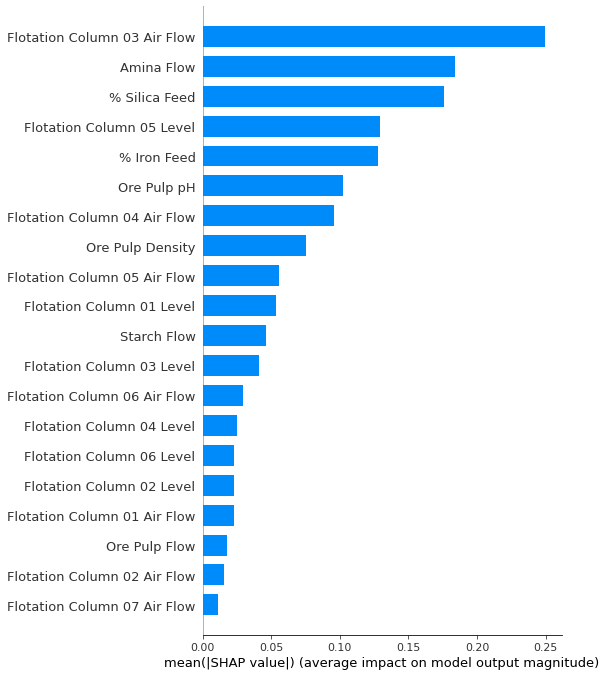

Wall time: 16.1 s


In [17]:
%%time
# explain part of the predictions in the test set
ex = shap.TreeExplainer(model_to_explain)
shap_values = ex.shap_values(sample)
shap.summary_plot(shap_values, sample, feature_names=temp_train_X.columns, plot_type="bar")

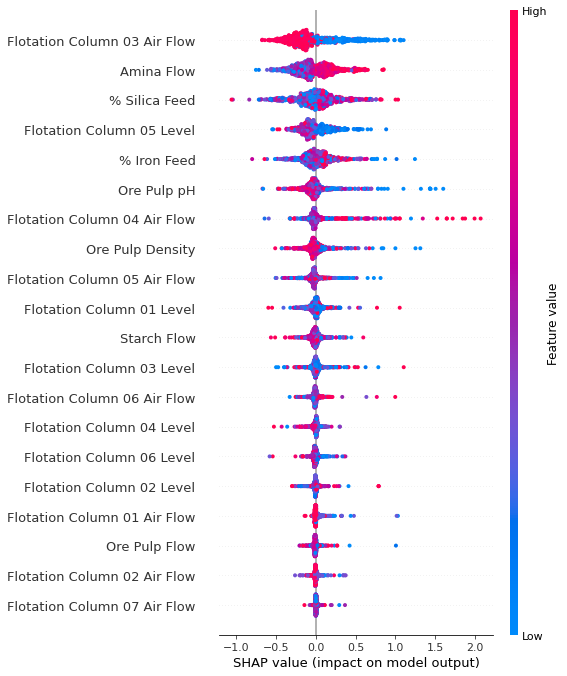

Wall time: 464 ms


In [18]:
%%time
shap.summary_plot(shap_values, sample, feature_names=temp_train_X.columns)

特徵重要性前三名為Flotation Column 03 Air Flow, Amina Flow, % Silica Feed  
Flotation Column 03 Air Flow 影響最大，顏色代表的是該特徵的值高低，而在x軸上的分布是計算出來的SHAP值，兩端點代表的是對模型的影響力  
初步可以解讀成隨著其Air Flow的增強其目標產出的降低，對於欲降低% Silica Concentrate 此目標而言是有用的  
Amina Flow反之，是在越多時會強化% Silica Concentrate的產出  

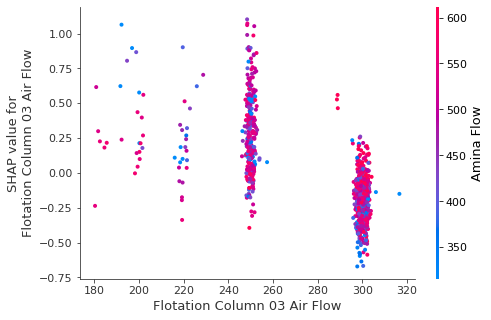

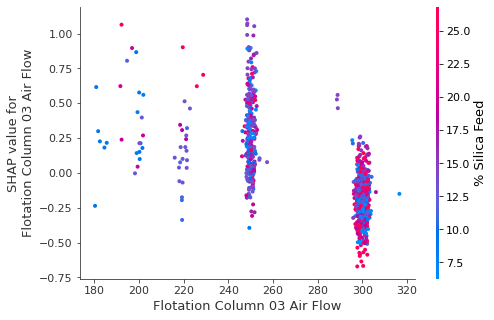

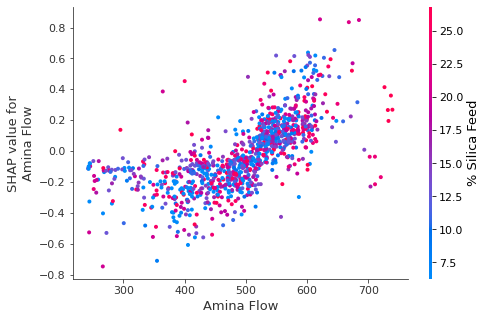

In [19]:
shap.dependence_plot("Flotation Column 03 Air Flow", shap_values, sample, interaction_index = "Amina Flow")
shap.dependence_plot("Flotation Column 03 Air Flow", shap_values, sample, interaction_index = "% Silica Feed")
shap.dependence_plot("Amina Flow", shap_values, sample, interaction_index = "% Silica Feed")

以上使用SHAP的PDP來看該特徵與其他交互項的關係，我們就單挑前三個影響力度較大的特徵來檢視其交互作用，大概可以看出一些關係:  
* Flotation Column 03 Air Flow 較高且Amina Flow較高時 SHAP值會偏低(negative)，會是降低目標產出的要素
* Flotation Column 03 Air Flow 較高且%Silica Feed較低時 SHAP值會偏低(negative)
* Amina Flow建強下與 % Silica Feed 的交互關係對目標應該沒有太大影響

## Explanation for prediction 

我們接下來針對單一的預測結果嘗試進行一些解讀  

In [20]:
tree_explainer = shap.TreeExplainer(Model)

data_for_prediction: 
% Iron Feed                       64.03000
% Silica Feed                      6.26000
Starch Flow                     3284.79000
Amina Flow                       384.12200
Ore Pulp Flow                    401.30000
Ore Pulp pH                       10.25790
Ore Pulp Density                   1.60925
Flotation Column 01 Air Flow     299.49600
Flotation Column 02 Air Flow     304.26100
Flotation Column 03 Air Flow     298.98000
Flotation Column 04 Air Flow     299.85100
Flotation Column 05 Air Flow     301.98000
Flotation Column 06 Air Flow     299.92700
Flotation Column 07 Air Flow     296.69800
Flotation Column 01 Level        607.40000
Flotation Column 02 Level        602.93900
Flotation Column 03 Level        602.84400
Flotation Column 04 Level        503.86100
Flotation Column 05 Level        491.95400
Flotation Column 06 Level        507.45600
Flotation Column 07 Level        493.73800
Name: 292500, dtype: float64
true y = 1.18



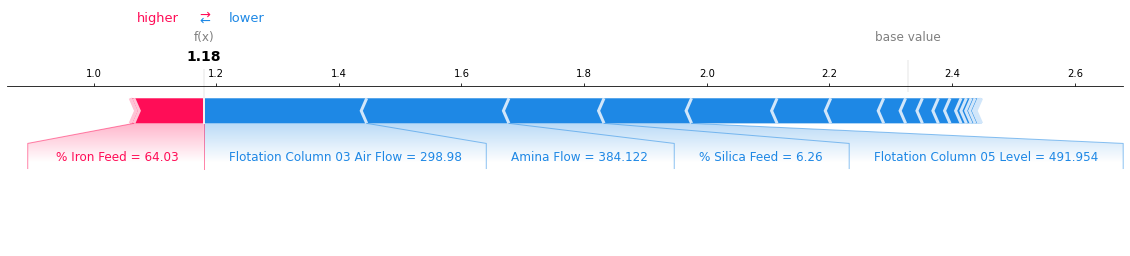

In [24]:
sample_row = 5
data_for_prediction = temp_test_X.iloc[sample_row]
print('data_for_prediction: \n{}'.format(data_for_prediction))
shap_values = tree_explainer.shap_values(data_for_prediction)
print('true y = {}\n'.format(test_y.iloc[sample_row]))
# shap.initjs()
shap.force_plot(tree_explainer.expected_value, shap_values, data_for_prediction, matplotlib = True)

由單一預測成果可以看到各特徵對於產出結果的影響力  
Flotation Column 03 Air Flow扮演重要腳色  
我們可以再抽取另一個sample data 比較  

data_for_prediction: 
% Iron Feed                       48.810000
% Silica Feed                     25.310000
Starch Flow                     3480.870000
Amina Flow                       459.649000
Ore Pulp Flow                    380.273000
Ore Pulp pH                       10.041200
Ore Pulp Density                   1.692440
Flotation Column 01 Air Flow     299.907000
Flotation Column 02 Air Flow     250.450000
Flotation Column 03 Air Flow     297.870000
Flotation Column 04 Air Flow     300.547000
Flotation Column 05 Air Flow     300.642733
Flotation Column 06 Air Flow     299.451000
Flotation Column 07 Air Flow     248.313000
Flotation Column 01 Level        554.575000
Flotation Column 02 Level        553.162000
Flotation Column 03 Level        559.022000
Flotation Column 04 Level        518.639000
Flotation Column 05 Level        562.547000
Flotation Column 06 Level        557.203000
Flotation Column 07 Level        573.671000
Name: 616331, dtype: float64
true y = 4.1582801664



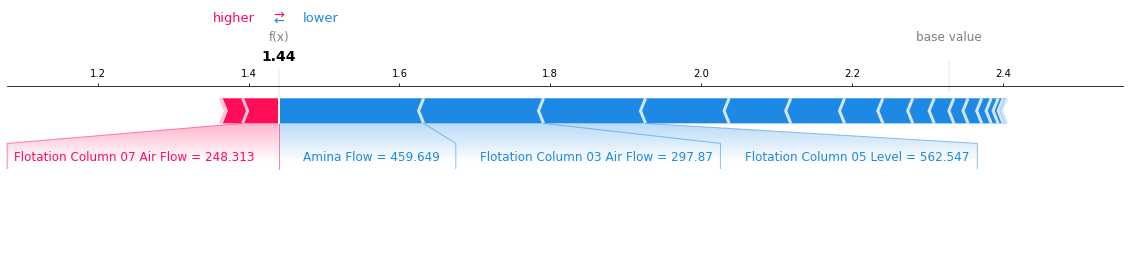

In [25]:
sample_row = 222
data_for_prediction = temp_train_X.iloc[sample_row]
print('data_for_prediction: \n{}'.format(data_for_prediction))
shap_values = tree_explainer.shap_values(data_for_prediction)
print('true y = {}\n'.format(test_y.iloc[sample_row]))
# shap.initjs()
shap.force_plot(tree_explainer.expected_value, shap_values, data_for_prediction, matplotlib = True)

# Hyperparameter Tuning

在前面我們挑選了合適的模型、藉模型完成了個別因子對產出目標的解釋力後，我們將更進一步嘗試去優化模型  
接下來將使用兩種手法來進行參數的調整並檢視模型成果  
1. 採用sklearn內建的參數優化方式  
2. 採用Optuna的參數優化方式

## Sklearn

這是大家最耳熟能詳的ML模組，我們將使用GridSearchCV來進行測試  
這邊要注意前面已經確認在深度為20左右比較不會發生overfit為前提下進行  

In [23]:
#重現
Model = DecisionTreeRegressor(max_depth = 20, random_state = 42)
Model.fit(temp_train_X, train_y)
    
print('model = ', Model)
    
preds = Model.predict(test_X)
rmse = mean_squared_error(test_y, preds, squared=False)
print('rmse = ', rmse)
print('train model R2 score = {}'.format(Model.score(temp_train_X, train_y)))
print('test model R2  score = {}'.format(Model.score(temp_test_X, test_y)))
print('params = {}'.format(Model.get_params()))
print('depth = {}'.format(Model.get_depth()))
print('nth_leaves = {}'.format(Model.get_n_leaves()))

model =  DecisionTreeRegressor(max_depth=20, random_state=42)
rmse =  0.47140214115778206
train model R2 score = 0.8824579593677713
test model R2  score = 0.8242634605087934
params = {'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
depth = 20
nth_leaves = 35058


In [24]:
%%time
#using the GridSearch function from sklearn 
parameters = {'max_depth': [12, 14, 16, 18, 20],
              'min_samples_split': [2, 10, 20, 40, 60, 80, 100],
              'max_features': ('auto', 'sqrt', 'log2'),
              'splitter': ('best', 'random')} 

Model = DecisionTreeRegressor(random_state = 42)
reg = GridSearchCV(Model, parameters)
reg.fit(temp_train_X, train_y)

Wall time: 44min 8s


GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [12, 14, 16, 18, 20],
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'min_samples_split': [2, 10, 20, 40, 60, 80, 100],
                         'splitter': ('best', 'random')})

In [25]:
print(reg.best_params_)
print(reg.best_score_)

{'max_depth': 20, 'max_features': 'auto', 'min_samples_split': 10, 'splitter': 'best'}
0.8218425725981036


In [26]:
print('train model R2 score = {}'.format(reg.score(temp_train_X, train_y)))
print('test model R2  score = {}'.format(reg.score(temp_test_X, test_y)))

train model R2 score = 0.8792676090278375
test model R2  score = 0.824697249452386


## Optuna

In [27]:
def objective(trial, data = feature, target = target_2):
    train_X, test_X, train_y, test_y = train_test_split(data, target, test_size = 0.3, random_state = 42)

    temp_train_X = train_X.copy()  
    param = {
        'max_depth': trial.suggest_int('max_depth', 12, 20, step = 1),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 100, step = 1),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random'])
    }
    
    temp_test_X = test_X.copy()
    model = DecisionTreeRegressor(random_state = 42, **param )
    model.fit(temp_train_X, train_y)
    preds = model.predict(temp_test_X)
    
    rmse = mean_squared_error(test_y, preds,squared = False)
    
    return rmse

In [28]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-07-10 14:08:59,093] A new study created in memory with name: no-name-91f157a9-6131-4c9b-bfdb-af19a68588eb
[I 2022-07-10 14:08:59,712] Trial 0 finished with value: 0.8953496164895249 and parameters: {'max_depth': 15, 'min_samples_split': 91, 'max_features': 'log2', 'splitter': 'random'}. Best is trial 0 with value: 0.8953496164895249.
[I 2022-07-10 14:09:10,702] Trial 1 finished with value: 0.6967632873373096 and parameters: {'max_depth': 14, 'min_samples_split': 78, 'max_features': 'auto', 'splitter': 'best'}. Best is trial 1 with value: 0.6967632873373096.
[I 2022-07-10 14:09:11,332] Trial 2 finished with value: 0.8652199133807803 and parameters: {'max_depth': 16, 'min_samples_split': 48, 'max_features': 'sqrt', 'splitter': 'random'}. Best is trial 1 with value: 0.6967632873373096.
[I 2022-07-10 14:09:11,967] Trial 3 finished with value: 0.860933773541887 and parameters: {'max_depth': 17, 'min_samples_split': 21, 'max_features': 'log2', 'splitter': 'random'}. Best is trial 1 w

Number of finished trials: 40
Best trial: {'max_depth': 20, 'min_samples_split': 7, 'max_features': 'auto', 'splitter': 'best'}
Wall time: 5min 35s


In [29]:
study.best_trial

FrozenTrial(number=12, values=[0.4704547736203571], datetime_start=datetime.datetime(2022, 7, 10, 14, 10, 0, 970425), datetime_complete=datetime.datetime(2022, 7, 10, 14, 10, 14, 696394), params={'max_depth': 20, 'min_samples_split': 7, 'max_features': 'auto', 'splitter': 'best'}, distributions={'max_depth': IntUniformDistribution(high=20, low=12, step=1), 'min_samples_split': IntUniformDistribution(high=100, low=2, step=1), 'max_features': CategoricalDistribution(choices=('auto', 'sqrt', 'log2')), 'splitter': CategoricalDistribution(choices=('best', 'random'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=12, state=TrialState.COMPLETE, value=None)

In [30]:
Model = DecisionTreeRegressor(max_depth = 20, min_samples_split = 7, max_features = 'auto', splitter = 'best', random_state = 42)
Model.fit(temp_train_X, train_y)
    
print('model = ', Model)
    
preds = Model.predict(test_X)
rmse = mean_squared_error(test_y, preds, squared=False)
print('rmse = ', rmse)
print('train model R2 score = {}'.format(Model.score(temp_train_X, train_y)))
print('test model R2  score = {}'.format(Model.score(temp_test_X, test_y)))
print('params = {}'.format(Model.get_params()))
print('depth = {}'.format(Model.get_depth()))
print('nth_leaves = {}'.format(Model.get_n_leaves()))

model =  DecisionTreeRegressor(max_depth=20, max_features='auto', min_samples_split=7,
                      random_state=42)
rmse =  0.4704547736203571
train model R2 score = 0.880790093778892
test model R2  score = 0.8249690992203196
params = {'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
depth = 20
nth_leaves = 21846


以結果而言，Optuna也能測出對於測試集一個較佳的模型結果  
兩者結果相仿，但Optuna在計算上速度更快(44分鐘對比5分鐘的效率差異非常大)    
以下是Optuna針對此Model可以進行的一些解釋

In [31]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.895350 2022-07-10 14:08:59.095030 2022-07-10 14:08:59.712766   
1        1  0.696763 2022-07-10 14:08:59.712766 2022-07-10 14:09:10.702216   
2        2  0.865220 2022-07-10 14:09:10.717809 2022-07-10 14:09:11.332133   
3        3  0.860934 2022-07-10 14:09:11.332133 2022-07-10 14:09:11.967950   
4        4  0.616767 2022-07-10 14:09:11.967950 2022-07-10 14:09:14.036189   
5        5  0.866765 2022-07-10 14:09:14.036189 2022-07-10 14:09:14.692706   
6        6  0.539719 2022-07-10 14:09:14.692706 2022-07-10 14:09:27.599181   
7        7  0.745606 2022-07-10 14:09:27.599181 2022-07-10 14:09:29.279870   
8        8  0.764649 2022-07-10 14:09:29.279870 2022-07-10 14:09:30.885647   
9        9  0.643859 2022-07-10 14:09:30.885647 2022-07-10 14:09:33.658770   
10      10  0.477124 2022-07-10 14:09:33.658770 2022-07-10 14:09:47.308457   
11      11  0.478108 2022-07-10 14:09:47.308457 2022-07-10 14:10:00.970425   
12      12  0.470455 2022-07-10 14:10:00.970425 2022-07-10 14:10:14.696394   
13      13  0.471402 2022-07-10 14:10:14.696394 2022-07-10 14:10:28.515010   
14      14  0.471402 2022-07-10 14:10:28.515010 2022-07-10 14:10:42.231165   
15      15  0.597550 2022-07-10 14:10:42.231165 2022-07-10 14:10:45.253523   
16      16  0.771579 2022-07-10 14:10:45.253523 2022-07-10 14:10:54.762187   
17      17  0.502412 2022-07-10 14:10:54.762187 2022-07-10 14:11:08.082739   
18      18  0.645009 2022-07-10 14:11:08.082739 2022-07-10 14:11:10.895034   
19      19  0.670543 2022-07-10 14:11:10.895034 2022-07-10 14:11:13.486796   
20      20  0.473997 2022-07-10 14:11:13.486796 2022-07-10 14:11:27.132555   
21      21  0.471584 2022-07-10 14:11:27.148190 2022-07-10 14:11:40.860173   
22      22  0.502412 2022-07-10 14:11:40.860173 2022-07-10 14:11:54.177867   
23      23  0.471402 2022-07-10 14:11:54.193488 2022-07-10 14:12:07.966751   
24      24  0.509138 2022-07-10 14:12:07.966751 2022-07-10 14:12:21.410888   
25      25  0.533201 2022-07-10 14:12:21.410888 2022-07-10 14:12:34.348054   
26      26  0.473958 2022-07-10 14:12:34.348054 2022-07-10 14:12:48.070093   
27      27  0.663958 2022-07-10 14:12:48.070093 2022-07-10 14:12:50.804748   
28      28  0.595756 2022-07-10 14:12:50.804748 2022-07-10 14:12:53.739471   
29      29  0.617702 2022-07-10 14:12:53.755092 2022-07-10 14:13:05.528235   
30      30  0.746611 2022-07-10 14:13:05.528235 2022-07-10 14:13:08.034364   
31      31  0.471635 2022-07-10 14:13:08.034364 2022-07-10 14:13:21.919811   
32      32  0.471402 2022-07-10 14:13:21.919811 2022-07-10 14:13:35.735994   
33      33  0.503178 2022-07-10 14:13:35.735994 2022-07-10 14:13:49.087817   
34      34  0.471176 2022-07-10 14:13:49.087817 2022-07-10 14:14:02.821498   
35      35  0.639276 2022-07-10 14:14:02.821498 2022-07-10 14:14:04.807781   
36      36  0.503349 2022-07-10 14:14:04.807781 2022-07-10 14:14:18.224468   
37      37  0.800793 2022-07-10 14:14:18.224468 2022-07-10 14:14:18.974954   
38      38  0.502933 2022-07-10 14:14:18.974954 2022-07-10 14:14:32.333737   
39      39  0.657923 2022-07-10 14:14:32.333737 2022-07-10 14:14:34.265480   

                 duration  params_max_depth params_max_features  \
0  0 days 00:00:00.617736                15                log2   
1  0 days 00:00:10.989450                14                auto   
2  0 days 00:00:00.614324                16                sqrt   
3  0 days 00:00:00.635817                17                log2   
4  0 days 00:00:02.068239                19                auto   
5  0 days 00:00:00.656517                17                sqrt   
6  0 days 00:00:12.906475                18                auto   
7  0 days 00:00:01.680689                14                auto   
8  0 days 00:00:01.605777                13                auto   
9  0 days 00:00:02.773123                18                log2   
10 0 days 00:00:13.649687                20                auto   
1

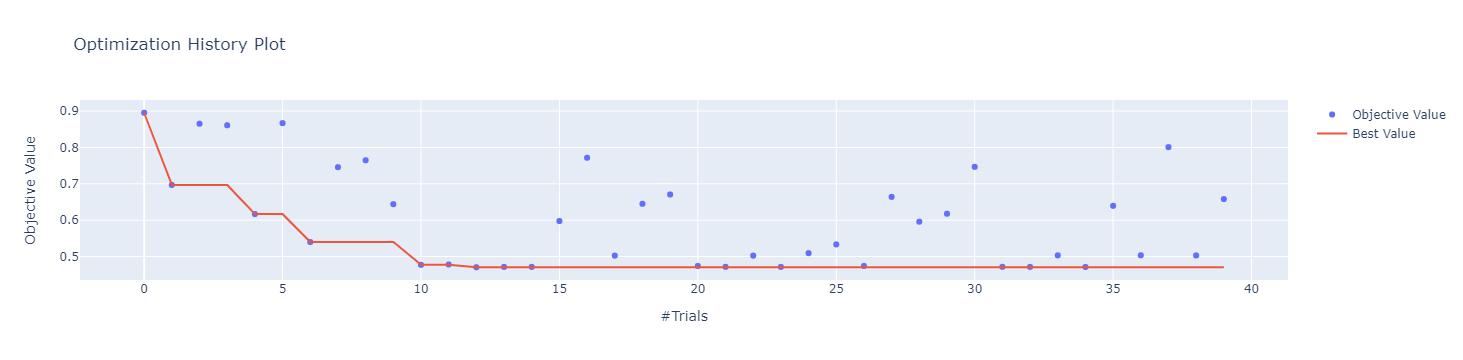

In [32]:
optuna.visualization.plot_optimization_history(study)

上圖是Optuna在訓練的trial次數增加下有向最佳目標收斂的視覺證明

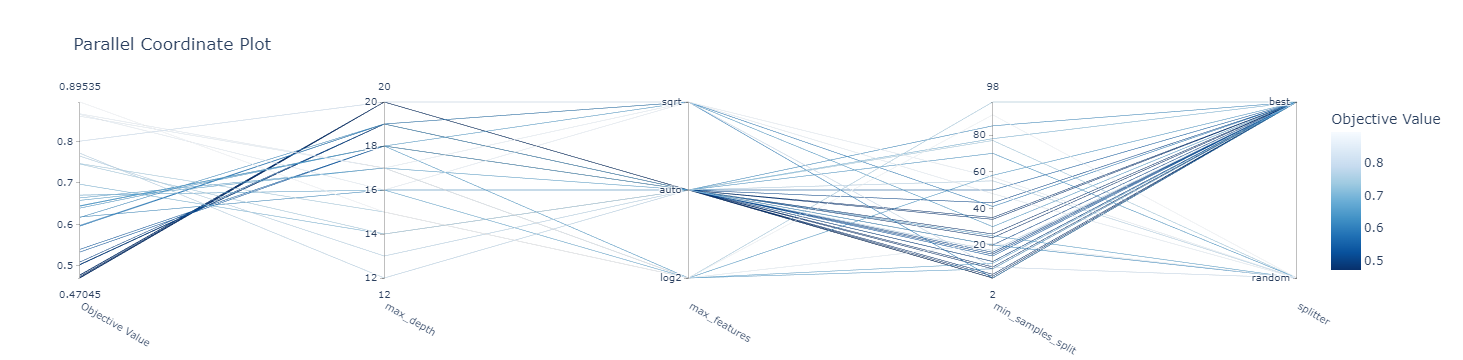

In [33]:
optuna.visualization.plot_parallel_coordinate(study)

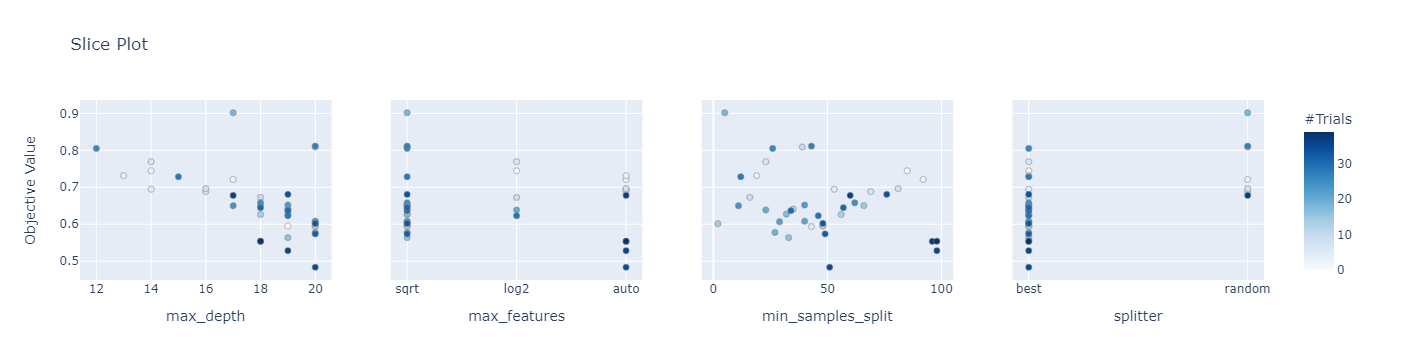

In [142]:
optuna.visualization.plot_slice(study)

藉由optuna的visualization tool我們可以看到超參數在嘗試下的行進方向  
深度自然是朝向20前進，其他參數則不一定  
下圖則是將其過程中因超參數變化對整個過程的影響重要度體現出來  

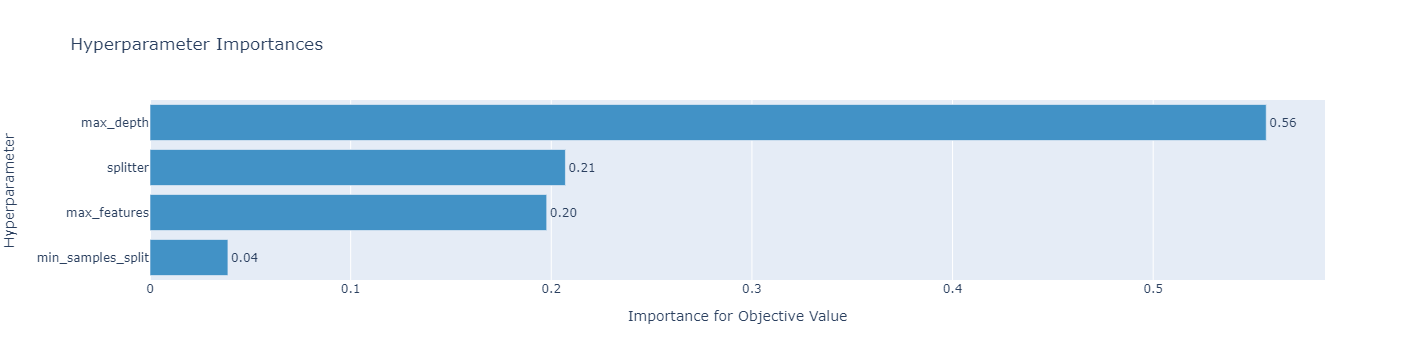

In [35]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

# Conclusion

本專案嘗試針對礦處理的輸入與輸出進行機器學習模型建模與分析，先檢視資料基本面，再來挑選合適的模型進行建模(為求速度本次不考慮訓練時間過長的模型)，最後選中了決策樹模型對資料進行解釋  
最後在看出相關模型的解釋性之後朝向模型本身優化的方向進行處理，使用了Sklearn基本的超參數優化方法與Optuna模組相互比較。  
截至目前為止本模型可以應用所有的參數完成對目標的預測，但是於實際應用上可能還是有落差，因實務上參數分為可控與不可控；並非可以馬上找到最佳產出的參數。
後續可以再進行優化的方向有以下幾點:  
*  嘗試使用其他ensemble model(like XGBOOST)  
*  深入了解本情境的可控變數與不可控變數，以此為出發點優化模型的應用  
*  在已知可控變數與不可控變數下，模擬並推演出每次輸入後可以調整的可控變數達到最小化目標的成果  
*  相關輸入參數於EDA階段中可見分布，但並未針對參數進行額外的前處理，針對各參數分布選用合適的縮放處理應該會強化模型的解釋力  

由於本資料的情境不是那麼的common knowledge，在此專案中會較偏重如何實作改善模型的參數，至此感謝你的撥冗閱讀~  